# Imports

In [1]:
import pandas as pd
import numpy as np

In [177]:
df = pd.read_csv('../3_3_2_processed_data/run1_survey_results.csv')

In [178]:
df.trial_date.min()

'2022-09-24'

In [179]:
df.trial_date.max()

'2022-10-26'

# Look at Gap Data

In [182]:
# specify relevant columns
cols = [
    'ParticipantIdentifier',
    'ResultIdentifier',
    'Answers',
    'trial_date'    
]

gap_vars = ['DAILY_goal1_report',
'DAILY_goal2_report',
'DAILY_past24_gap']

# create dataframe with gap data
df = df.loc[df.ResultIdentifier.isin(gap_vars), df.columns.isin(cols)]

# convert to numeric
df.Answers = pd.to_numeric(df.Answers)

# make it gap (instead of success)
df.loc[df.ResultIdentifier.str.endswith('report'), 'Answers'] = 100 - df.loc[df.ResultIdentifier.str.endswith('report'), 'Answers']

# convert wide to long
df = df.pivot_table(index=["ParticipantIdentifier", "trial_date"], 
                    columns='ResultIdentifier', 
                    values='Answers').reset_index()

# calculate gap, weighting daily specific goals arbitrarily at 1/3
df['gap'] = df.DAILY_goal1_report/6 + df.DAILY_goal2_report/6 + df.DAILY_past24_gap * 2/3

# select only subjects that have data from most days
day_count = pd.DataFrame(df.groupby('ParticipantIdentifier').count()['trial_date']).reset_index()
good_subjects = day_count[day_count.trial_date>20].ParticipantIdentifier

df = df.loc[df.ParticipantIdentifier.isin(good_subjects)]

df.head()

In [188]:
day_count = pd.DataFrame(df.groupby('ParticipantIdentifier').count()['trial_date']).reset_index()
good_subjects = day_count[day_count.trial_date>20].ParticipantIdentifier

In [189]:
df = df.loc[df.ParticipantIdentifier.isin(good_subjects)]

# Categorize Data by Participant

In [191]:
df.isnull().sum()

ResultIdentifier
ParticipantIdentifier     0
trial_date                0
DAILY_goal1_report       80
DAILY_goal2_report       80
DAILY_past24_gap          0
gap                      80
dtype: int64

In [192]:
df.gap.fillna(df.DAILY_past24_gap, inplace=True)

In [193]:
medians = pd.DataFrame(df.groupby(['ParticipantIdentifier'])['gap'].median()).reset_index()

In [194]:
medians.rename(columns={'gap': 'medians'}, inplace=True)

In [195]:
df = df.merge(medians, how='left', on='ParticipantIdentifier')

In [210]:
df.head()

,ParticipantIdentifier,trial_date,DAILY_goal1_report,DAILY_goal2_report,DAILY_past24_gap,gap,medians,cat3,cat2
0,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-09-27,100.0,14.0,32.0,40.333333,38.5,1,1
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-09-30,52.0,23.0,26.0,29.833333,38.5,0,0
2,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-10-01,24.0,39.0,28.0,29.166667,38.5,0,0
3,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-10-02,43.0,100.0,22.0,38.500000,38.5,1,0
4,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-10-03,35.0,35.0,23.0,27.000000,38.5,0,0


In [203]:
df['cat2'] = df.groupby(['ParticipantIdentifier'])[['gap']].transform(lambda x: pd.qcut(x, 2, labels=[0,1]))

In [201]:
df['cat3'] = df.groupby(['ParticipantIdentifier'])[['gap']].transform(lambda x: pd.qcut(x, 3, labels=[0,1,2]))

# Calculate Transition Matrices

In [209]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = np.zeros((n,n))

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    M = M/M.sum(axis=1, keepdims=True)
    return M

## Example Participant

In [367]:
i = 4

In [368]:
ex2 = np.around(transition_matrix(df.loc[df.ParticipantIdentifier==subjects[i], 'cat2']), 2)
ex3 = np.around(transition_matrix(df.loc[df.ParticipantIdentifier==subjects[i], 'cat3']), 2)

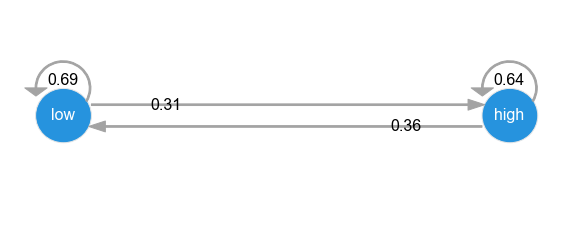

In [369]:
mc = MarkovChain(ex2, ['low', 'high'])
mc.draw()

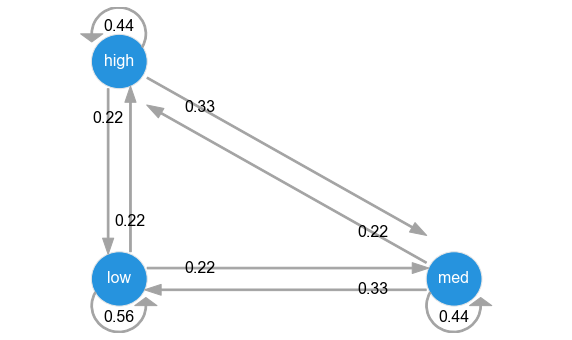

In [370]:
mc = MarkovChain(ex3, ['low', 'med', 'high'])
mc.draw()

In [348]:
d = {'gap': df.loc[df.ParticipantIdentifier==subjects[i], 'gap'],
     'cat': df.loc[df.ParticipantIdentifier==subjects[i], 'cat2']
    }

In [351]:
trace = pd.DataFrame.from_dict(d).reset_index()

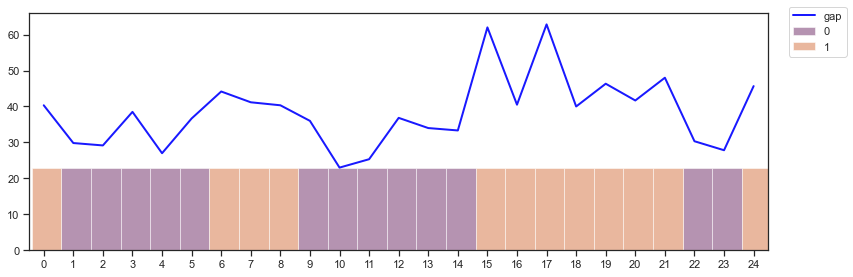

In [356]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(trace.index, trace.gap, color='blue', linewidth=2, alpha=0.9, label="gap")

sns.barplot(x=trace.index, y=[trace['gap'].min()] * len(trace),
            hue='cat', alpha=0.5, palette='inferno', dodge=False, data=trace, ax=ax1)
for bar in ax1.patches: # optionally set the bars to fill the complete background, default seaborn sets the width to about 80%
    bar.set_width(1)

plt.legend(bbox_to_anchor=(1.02, 1.05) , loc='upper left')
plt.tight_layout()
plt.show()

## All Participants

In [316]:
trans2 = []

for subject in np.unique(df.ParticipantIdentifier):
    temp = transition_matrix(df.loc[df.ParticipantIdentifier==subject, 'cat2']).reshape(4)
    if len(trans2) == 0:
        trans2 = temp
    else:
        trans2 = np.vstack((trans2, temp))

In [320]:
trans2 = pd.DataFrame(trans2, columns = [
    'low-low', 
    'low-high',
    'high-low',
    'high=high'
    ])

In [327]:
trans2_wide = pd.melt(trans2,
                      var_name='transition',
                      value_name='prob')

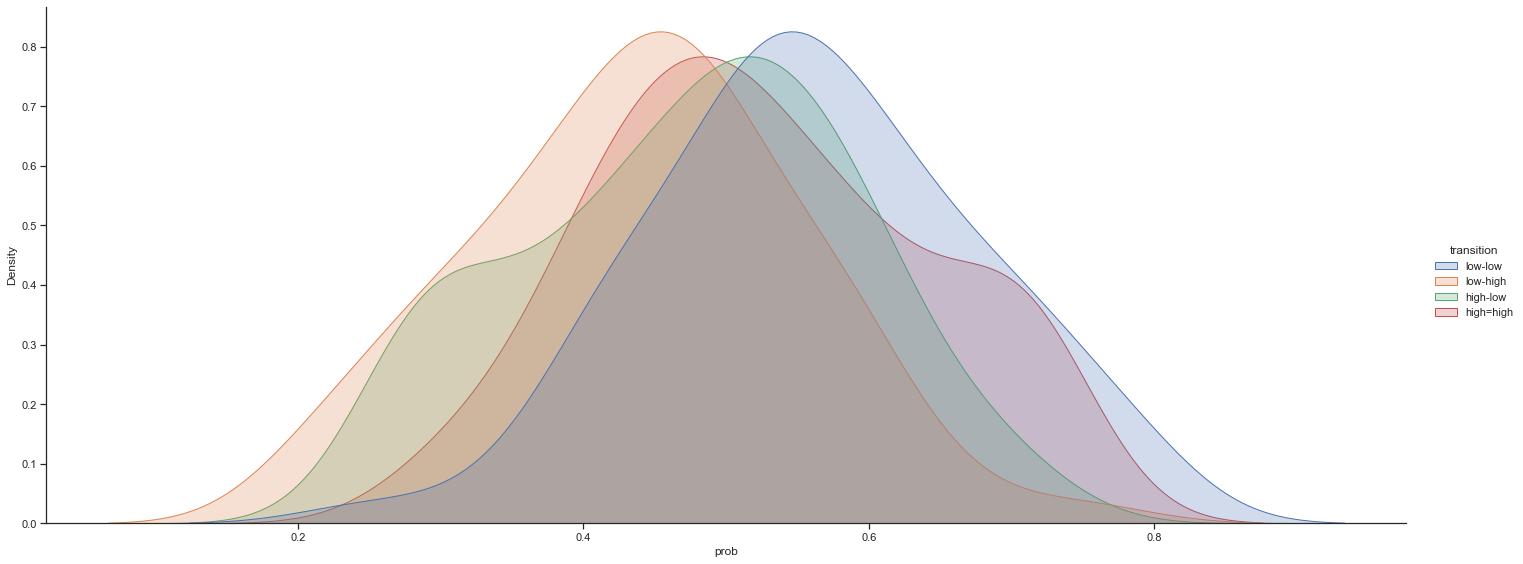

In [343]:
sns.set_style('ticks')

sns.displot(trans2_wide, x="prob", hue="transition", kind="kde", fill=True, height = 8, aspect = 2.5);

In [ ]:
https://towardsdatascience.com/advanced-visualization-techniques-for-time-series-analysis-14eeb17ec4b0

# Hierarchical Hidden Markov Model
- https://towardsdatascience.com/hierarchical-hidden-markov-models-a9e0552e70c1

In [ ]:
perosnalized ML models from Webb

# Helper Functions

https://naysan.ca/2020/07/08/drawing-state-transition-diagrams-in-python/

In [254]:
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

class Node():
    
    def __init__(
        self, center, radius, label, 
        facecolor='#2693de', edgecolor='#e6e6e6',
        ring_facecolor='#a3a3a3', ring_edgecolor='#a3a3a3'
        ):
        """
        Initializes a Markov Chain Node(for drawing purposes)
        Inputs:
            - center : Node (x,y) center
            - radius : Node radius
            - label  : Node label
        """
        self.center = center
        self.radius = radius
        self.label  = label

        # For convinience: x, y coordinates of the center
        self.x = center[0]
        self.y = center[1]
        
        # Drawing config
        self.node_facecolor = facecolor
        self.node_edgecolor = edgecolor
        
        self.ring_facecolor = ring_facecolor
        self.ring_edgecolor = ring_edgecolor
        self.ring_width = 0.03  
        
        self.text_args = {
            'ha': 'center', 
            'va': 'center', 
            'fontsize': 16
        }
    
    
    def add_circle(self, ax):
        """
        Add the annotated circle for the node
        """
        circle = mpatches.Circle(self.center, self.radius)
        p = PatchCollection(
            [circle], 
            edgecolor = self.node_edgecolor, 
            facecolor = self.node_facecolor
        )
        ax.add_collection(p)
        ax.annotate(
            self.label, 
            xy = self.center, 
            color = '#ffffff', 
            **self.text_args
        )
        
        
    def add_self_loop(self, ax, prob=None, direction='up'):
        """
        Draws a self loop
        """
        if direction == 'up':
            start = -30
            angle = 180
            ring_x = self.x
            ring_y = self.y + self.radius
            prob_y = self.y + 1.3*self.radius
            x_cent = ring_x - self.radius + (self.ring_width/2)
            y_cent = ring_y - 0.15
        else:
            start = -210
            angle = 0
            ring_x = self.x
            ring_y = self.y - self.radius
            prob_y = self.y - 1.4*self.radius
            x_cent = ring_x + self.radius - (self.ring_width/2)
            y_cent = ring_y + 0.15
            
        # Add the ring
        ring = mpatches.Wedge(
            (ring_x, ring_y), 
            self.radius, 
            start, 
            angle, 
            width = self.ring_width
        )
        # Add the triangle (arrow)
        offset = 0.2
        left   = [x_cent - offset, ring_y]
        right  = [x_cent + offset, ring_y]
        bottom = [(left[0]+right[0])/2., y_cent]
        arrow  = plt.Polygon([left, right, bottom, left])

        p = PatchCollection(
            [ring, arrow], 
            edgecolor = self.ring_edgecolor, 
            facecolor = self.ring_facecolor
        )
        ax.add_collection(p)
        
        # Probability to add?
        if prob:
            ax.annotate(str(prob), xy=(self.x, prob_y), color='#000000', **self.text_args)

In [255]:
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

class MarkovChain:

    def __init__(self, M, labels):
        """
        Initializes a Markov Chain (for drawing purposes)
        Inputs:
            - M         Transition Matrix
            - labels    State Labels
        """

        if M.shape[0] < 2:
            raise Exception("There should be at least 2 states")
        if M.shape[0] > 4:
            raise Exception("Only works with 4 states max for now")
        if M.shape[0] != M.shape[1]:
            raise Exception("Transition matrix should be square")
        if M.shape[0] != len(labels):
            raise Exception("There should be as many labels as states")

        self.M = M
        self.n_states = M.shape[0]
        self.labels = labels

        # Colors
        self.arrow_facecolor = '#a3a3a3'
        self.arrow_edgecolor = '#a3a3a3'

        self.node_facecolor = '#2693de'
        self.node_edgecolor = '#e6e6e6'

        # Drawing config
        self.node_radius = 0.5
        self.arrow_width = 0.03
        self.arrow_head_width = 0.20
        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': 16
        }

        # Build the network
        self.build_network()


    def set_node_centers(self):
        """
        Positions the node centers given the number of states
        """
        # Node positions
        self.node_centers = []

        if self.n_states == 2:
            self.figsize = (10, 4)
            self.xlim = (-5, 5)
            self.ylim = (-2, 2)
            self.node_centers = [[-4,0], [4,0]]
        elif self.n_states == 3:
            self.figsize = (10, 6)
            self.xlim = (-5, 5)
            self.ylim = (-3, 3)
            self.node_centers = [[-3,-2], [3,-2], [-3,2]]
        elif self.n_states == 4:
            self.figsize = (8, 8)
            self.xlim = (-5, 5)
            self.ylim = (-5, 5)
            self.node_centers = [[-4,4], [4,4], [4,-4], [-4,-4]]


    def build_network(self):
        """
        Loops through the matrix, add the nodes
        """
        # Position the node centers
        self.set_node_centers()

        # Set the nodes
        self.nodes = []
        for i in range(self.n_states):
            node = Node(
                self.node_centers[i],
                self.node_radius,
                self.labels[i]
            )
            self.nodes.append(node)


    def add_arrow(self, ax, node1, node2, prob=None):
        """
        Add a directed arrow between two nodes
        """
        # x,y start of the arrow
        x_start = node1.x + np.sign(node2.x-node1.x) * node1.radius
        y_start = node1.y + np.sign(node2.y-node1.y) * node1.radius

        # arrow length
        dx = abs(node1.x - node2.x) - 2.5* node1.radius
        dy = abs(node1.y - node2.y) - 2.5* node1.radius

        # we don't want xoffset and yoffset to both be non-nul
        yoffset = 0.4 * self.node_radius * np.sign(node2.x-node1.x)
        if yoffset == 0:
            xoffset = 0.4 * self.node_radius * np.sign(node2.y-node1.y)
        else:
            xoffset = 0

        arrow = mpatches.FancyArrow(
            x_start + xoffset,
            y_start + yoffset,
            dx * np.sign(node2.x-node1.x),
            dy * np.sign(node2.y-node1.y),
            width = self.arrow_width,
            head_width = self.arrow_head_width
        )
        p = PatchCollection(
            [arrow],
            edgecolor = self.arrow_edgecolor,
            facecolor = self.arrow_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        x_prob = x_start + xoffset + 0.2*dx*np.sign(node2.x-node1.x)
        y_prob = y_start + yoffset + 0.2*dy*np.sign(node2.y-node1.y)
        if prob:
            ax.annotate(str(prob), xy=(x_prob, y_prob), color='#000000', **self.text_args)


    def draw(self, img_path=None):
        """
        Draw the Markov Chain
        """
        fig, ax = plt.subplots(figsize=self.figsize)

        # Set the axis limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        # Draw the nodes
        for node in self.nodes:
            node.add_circle(ax)

        # Add the transitions
        for i in range(self.M.shape[0]):
            for j in range(self.M.shape[1]):
                # self loops
                if i == j:
                    # Loop direction
                    if self.nodes[i].y >= 0:
                        self.nodes[i].add_self_loop(ax, prob = self.M[i,j], direction='up')
                    else:
                        self.nodes[i].add_self_loop(ax, prob = self.M[i,j], direction='down')
                # directed arrows
                elif self.M[i,j] > 0:
                    self.add_arrow(ax, self.nodes[i], self.nodes[j], prob = self.M[i,j])

        plt.axis('off')
        # Save the image to disk?
        if img_path:
            plt.savefig(img_path)
        plt.show()

In [386]:
newSub = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_1_gap_measure/3_1_1_raw_data/SONA/IB_numeric_SONA_vOct2022_28112022.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_77409/277090442.py:1: DtypeWarning: Columns (2,4,5,6,9,10,11,12,13,14,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,73,74,75,76,77,78,80,81,82,83,84,85,87,88,89,90,91,92,94,95,96,97,98,99,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,26

In [387]:
newSub = newSub.loc[2:,].reset_index(drop=True)

In [391]:
x = newSub.loc[newSub.retest_app_select_5=='1', 'retest_app_email']